In [73]:
!pip install -qU langchain langchain-community langchain-groq langchain-experimental neo4j tiktoken wikipedia yfiles_jupyter_graphs sentence-transformers

In [72]:
from langchain_core.runnables import (
    RunnableBranch,
RunnableLambda,
RunnableParallel,
RunnablePassthrough,
)
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.prompts.prompt import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import Tuple, List, Optional
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
import os
from langchain_community.graphs import Neo4jGraph
from langchain.document_loaders import WikipediaLoader
from langchain.text_splitter import TokenTextSplitter
from langchain_groq import ChatGroq
from langchain_experimental.graph_transformers import LLMGraphTransformer
from neo4j import GraphDatabase
from yfiles_jupyter_graphs import GraphWidget
from langchain_community.vectorstores import Neo4jVector
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.neo4j_vector import remove_lucene_chars
from langchain_core.runnables import ConfigurableField, RunnableParallel, RunnablePassthrough

In [74]:
from langchain.chains import GraphCypherQAChain
from langchain_community.graphs import Neo4jGraph
graph = Neo4jGraph(url="bolt://localhost:7687", username="neo4j", password="password")

In [78]:
raw_documents = WikipediaLoader(query="Ratan Tata").load()
text_splitter = TokenTextSplitter(chunk_size=512, chunk_overlap=24)
documents = text_splitter.split_documents(raw_documents[:3])

In [ ]:
from dotenv import load_dotenv
load_dotenv()
import os
groq_api_key = os.getenv("GROQ_API_KEY")
langsmith_api_key = os.getenv("LANGSMITH_API_KEY")


In [ ]:
llm= ChatGroq(temperature=0,model_name="llama3-8b-8192")

In [84]:
llm_transformer = LLMGraphTransformer(llm=llm)
graph_documents = llm_transformer.convert_to_graph_documents(documents)
graph.add_graph_documents(graph_documents,
baseEntityLabel=True,
include_source=True)

In [85]:
default_cypher = "MATCH (s)-[r:MENTIONS]->(t) RETURN s,r,t LIMIT 50"

def showGraph(cypher: str = default_cypher):
    driver = GraphDatabase.driver(
        uri=os.environ["NEO4J_URI"],
        auth=(os.environ["NEO4J_USERNAME"], os.environ["NEO4J_PASSWORD"])
    )
    session = driver.session()
    widget = GraphWidget(graph=session.run(cypher).graph())
    widget.node_label_mapping = 'id'
    #display(widget)
    return widget

In [86]:
showGraph()

GraphWidget(layout=Layout(height='800px', width='100%'))

/tmp/ipykernel_1417/1673180733.py:20: DeprecationWarning: `id` is deprecated, use `element_id` instead
  G.add_node(node.id, label=node.get('id', ''))
/tmp/ipykernel_1417/1673180733.py:22: DeprecationWarning: `id` is deprecated, use `element_id` instead
  G.add_edge(relationship.start_node.id, relationship.end_node.id)


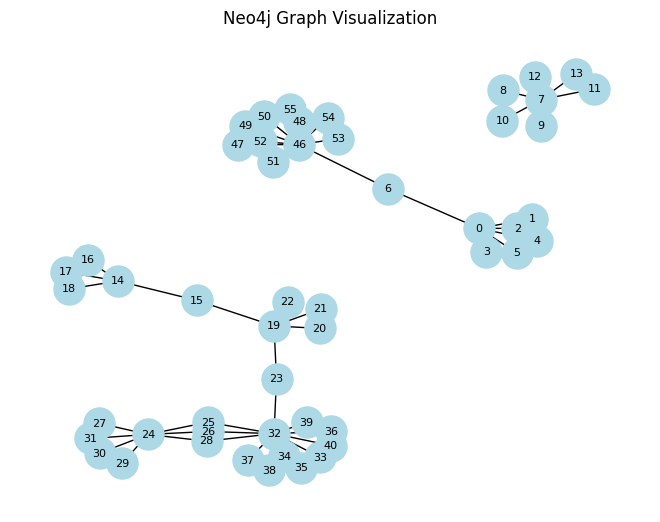

In [87]:
import networkx as nx
import matplotlib.pyplot as plt
from neo4j import GraphDatabase
import os

def visualize_graph(cypher_query):
    # Get Neo4j connection details from environment variables
    uri = os.environ.get("NEO4J_URI", "bolt://localhost:7687")
    username = os.environ.get("NEO4J_USERNAME", "neo4j")
    password = os.environ.get("NEO4J_PASSWORD", "password")

    driver = GraphDatabase.driver(uri, auth=(username, password))
    with driver.session() as session:
        result = session.run(cypher_query)
        graph = result.graph()

    # Create a NetworkX graph
    G = nx.Graph()
    for node in graph.nodes:
        G.add_node(node.id, label=node.get('id', ''))
    for relationship in graph.relationships:
        G.add_edge(relationship.start_node.id, relationship.end_node.id)

    # Draw the graph
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=8, arrows=True)
    plt.title("Neo4j Graph Visualization")
    plt.axis('off')
    plt.show()

# Use the function
visualize_graph("MATCH (s)-[r:MENTIONS]->(t) RETURN s,r,t LIMIT 50")

In [91]:
graph.refresh_schema()

In [92]:
print(graph.schema)

Node properties:
Document {text: STRING, id: STRING, summary: STRING, source: STRING, title: STRING}
Person {id: STRING}
Team {id: STRING}
Organization {id: STRING}
Competition {id: STRING}
Country {id: STRING}
Cricket team {id: STRING}
Movie {name: STRING, runtime: INTEGER}
Actor {name: STRING}
School {id: STRING}
University {id: STRING}
Company {id: STRING}
Group {id: STRING}
Collection {id: STRING}
Relationship properties:

The relationships:
(:Document)-[:MENTIONS]->(:Person)
(:Document)-[:MENTIONS]->(:Team)
(:Document)-[:MENTIONS]->(:Cricket team)
(:Document)-[:MENTIONS]->(:Competition)
(:Document)-[:MENTIONS]->(:Country)
(:Document)-[:MENTIONS]->(:Organization)
(:Document)-[:MENTIONS]->(:School)
(:Document)-[:MENTIONS]->(:Company)
(:Document)-[:MENTIONS]->(:University)
(:Document)-[:MENTIONS]->(:Collection)
(:Document)-[:MENTIONS]->(:Group)
(:Person)-[:SPOUSE]->(:Person)
(:Person)-[:PARENT]->(:Person)
(:Person)-[:INSPIRATION]->(:Person)
(:Person)-[:NAMESAKE]->(:Person)
(:Person)-